In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows =1600

# Scikit Learn
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Other Tools
import lazypredict
from lazypredict.Supervised import LazyRegressor
import shap
from joblib import dump, load

In [27]:

ndvi_df = pd.read_csv('NDVI_clean_preprocessed_shorttermdrought.csv')
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df = ndvi_df.set_index('date')


columns_to_rename = [col for col in ndvi_df .columns if col.endswith('_anomaly_roll')]


rename_dict = {col: col[:-len('_anomaly_roll')].upper() for col in columns_to_rename}

ndvi_df .rename(columns=rename_dict, inplace=True)
ndvi_df .rename(columns={'TMIN': 'Tmin', 'TMAX': 'Tmax', 'PRECIP': 'Precip', 'PALMERZ': 'PalmerZ',}, inplace=True)


ndvi_df

,NDVI,SWE,Tmin,Tmax,Precip,PDSI,EDDI30,EDDI90,EDDI180,SPEI30,SPEI90,SPEI180,SPI30,SPI90,SPI180,PalmerZ
date,,,,,,,,,,,,,,,,
2000-02-29,0.78,0.02,3.87,3.20,0.59,0.57,0.33,0.19,0.50,0.18,-0.05,-0.46,0.82,0.34,-0.51,0.22
2000-03-05,0.36,-0.43,3.35,3.17,0.14,0.56,0.57,0.30,0.61,-0.06,-0.11,-0.66,0.70,0.33,-0.77,0.10
2000-03-10,0.29,-0.81,2.55,2.29,1.80,0.56,0.61,0.33,0.68,0.29,0.08,-0.68,1.12,0.65,-0.69,0.42
2000-03-15,0.07,-0.92,1.68,1.55,1.17,0.57,0.64,0.29,0.71,0.39,0.24,-0.69,1.22,0.84,-0.63,0.51
2000-03-20,0.01,-0.95,1.25,1.19,1.11,0.58,0.63,0.27,0.76,0.47,0.35,-0.71,1.30,0.97,-0.58,0.58
2000-03-25,-0.09,-1.03,0.96,0.99,0.75,0.60,0.66,0.30,0.87,0.51,0.48,-0.80,1.35,1.16,-0.61,0.64
2000-03-30,-0.17,-1.18,0.38,0.55,0.36,0.62,0.54,0.26,0.97,0.61,0.59,-0.87,1.38,1.24,-0.60,0.70
2000-04-04,-0.14,-1.18,-0.19,-0.10,0.32,0.64,0.33,0.19,1.02,0.76,0.70,-0.86,1.38,1.33,-0.47,0.79
2000-04-09,-0.19,-1.03,-0.36,-0.15,-0.85,0.65,0.22,0.18,1.04,0.39,0.60,-0.89,0.74,1.15,-0.46,0.41


Data_slicin

In [20]:
from sklearn import tree
X = ndvi_df .iloc[:,1:16].values
Y = ndvi_df .iloc[:,0:1].values.ravel()
tre = tree.DecisionTreeRegressor()

In [30]:
tre

DecisionTreeRegressor()

In [31]:
X_train = ndvi_df .iloc[0:1272, 1:16].values
Y_train = ndvi_df .iloc[0:1272, 0:1].values.ravel()
X_test = ndvi_df .iloc[1272:1590, 1:16].values
Y_test = ndvi_df .iloc[1272:1590, 0:1].values

<Axes: ylabel='Count'>

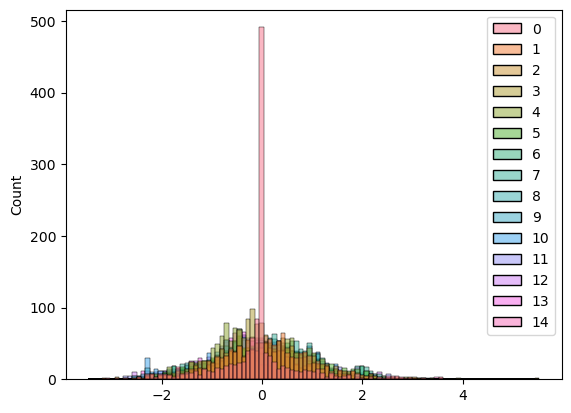

In [50]:
import seaborn as sns
sns.histplot(X_train)

<Axes: ylabel='Count'>

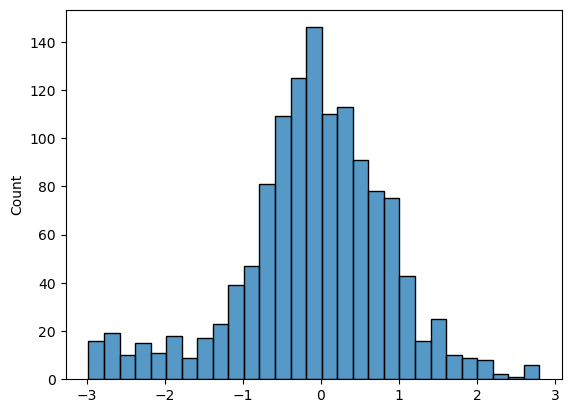

In [73]:
sns.histplot(Y_train)

<Axes: >

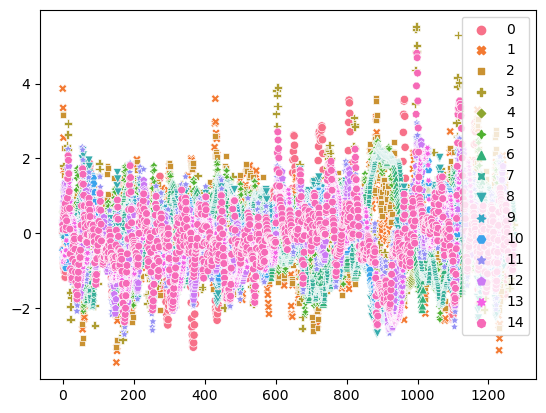

In [74]:
sns.scatterplot(X_train)

<Axes: >

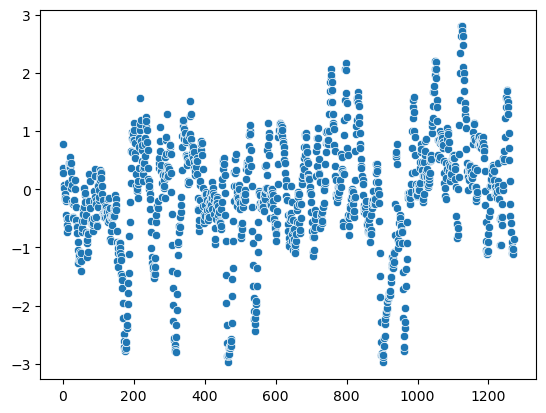

In [75]:
sns.scatterplot(Y_train)

In [57]:
tre.fit(X_train, Y_train)
Y_predicted = tre.predict(X_test)


score=tre.score(X_test, Y_test)

In [58]:
score

0.141020463411188

In [63]:

from sklearn import svm

X = ndvi_df.iloc[:,1:16].values
Y = ndvi_df.iloc[:,0:1].values.ravel()

reg = svm.SVR()


In [64]:
X_train = ndvi_df.iloc[0:1272, 1:16].values
Y_train = ndvi_df.iloc[0:1272, 0:1].values.ravel()
X_test = ndvi_df.iloc[1272:1590, 1:16].values
Y_test = ndvi_df.iloc[1272:1590, 0:1].values


In [65]:
reg.fit(X_train, Y_train)
Y_predicted = reg.predict(X_test)


reg.score(X_test, Y_test)

0.28959003661328386

In [66]:

X = ndvi_df.iloc[:, 1:16].values
y = ndvi_df.iloc[:, 0:1].values.ravel()

In [67]:

etr_model = ExtraTreesRegressor(random_state=42)


num_folds = 5


kfold = KFold(n_splits=num_folds, shuffle=False)


results = cross_val_score(etr_model, X, y, cv=kfold, scoring='r2')


print("Test Set Results:", results)
print("Test Set Mean Result:", results.mean())


Test Set Results: [0.5315005  0.55270563 0.52870312 0.23788574 0.46805681]
Test Set Mean Result: 0.4637703610228286


In [68]:

xgb_model = XGBRegressor(random_state=42)


num_folds = 5


kfold = KFold(n_splits=num_folds, shuffle=False)


results = cross_val_score(xgb_model, X, y, cv=kfold, scoring='r2')

print("Test Set Results:", results)
print("Test Set Mean Result:", results.mean())

Test Set Results: [0.53050114 0.44966813 0.47919826 0.17877771 0.41792238]
Test Set Mean Result: 0.4112135235786932


In [69]:

X = ndvi_df.iloc[:, 1:16].values
y = ndvi_df.iloc[:, 0:1].values.ravel()


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape - x_train: ", x_train.shape)
print("Training data shape - y_train: ", y_train.shape)
print("Testing data shape - x_test: ", x_test.shape)
print("Testing data shape - y_test: ", y_test.shape)


Training data shape - x_train:  (1272, 15)
Training data shape - y_train:  (1272,)
Testing data shape - x_test:  (318, 15)
Testing data shape - y_test:  (318,)


In [70]:

etr_model = ExtraTreesRegressor(random_state=42)


num_folds = 5


kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)


results = cross_val_score(etr_model, x_train, y_train, cv=kfold, scoring='r2')


etr_model.fit(x_train, y_train)


y_pred = etr_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)


Cross Val Results: [0.92448104 0.94321891 0.93044046 0.94259361 0.92063844]
Cross Val Mean Result: 0.9322744938539509
Test Mean Squared Error: 0.5537734887298728
Test Root Mean Squared Error: 0.7441595855257612
Test R-squared: 0.4680568138118374


In [71]:

xgb_model = XGBRegressor(random_state=42)


num_folds = 5


kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)


results = cross_val_score(xgb_model, x_train, y_train, cv=kfold, scoring='r2')

xgb_model.fit(x_train, y_train)


y_pred = xgb_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)

Cross Val Results: [0.87059425 0.88924363 0.91092339 0.8863673  0.87576748]
Cross Val Mean Result: 0.8865792090906057
Test Mean Squared Error: 0.6059653812930572
Test Root Mean Squared Error: 0.7784377825446663
Test R-squared: 0.41792237764204576
